# MOSAIKS Featurization Demonstration

Text - GPU etc



## Setup

Install rasterio for satellite image processing, then loaad the libraries neccessary image processing.

In [ ]:
!pip install rasterio

In [ ]:
import os
import time
import torch
import shutil
import rasterio
import numpy as np
import pandas as pd

from google.colab import drive
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple, Union, Callable, Any, Optional

## Activation map example

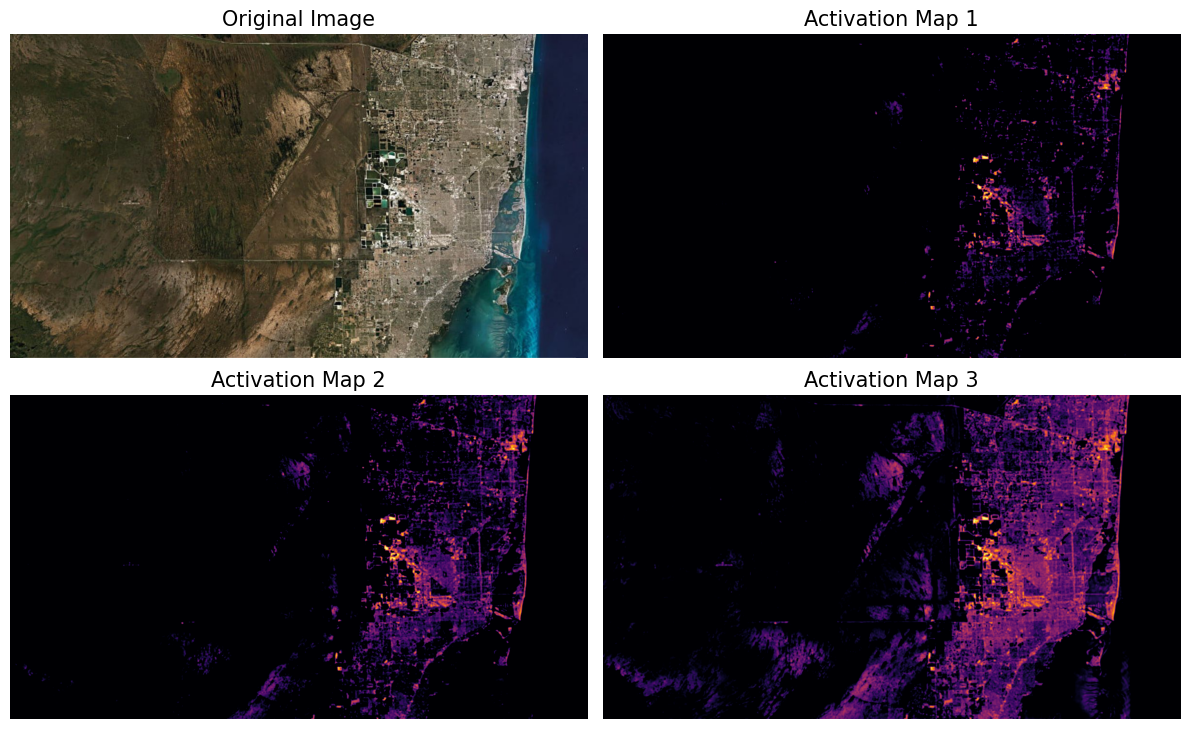

In [1]:
import torch.nn as nn
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms


class RCFWithPatchSampling(nn.Module):
    """
    A model for extracting Random Convolution Features (RCF) with patch sampling
    from the input image for empirical convolution kernels.
    """

    def __init__(
        self,
        num_features=6,  # Number of features to compute (must be divisible by 2)
        kernel_size=3,
        num_input_channels=3,
        patch_sampling=True,  # Enable empirical patch sampling
        seed=42,  # Seed for reproducibility
    ):
        super(RCFWithPatchSampling, self).__init__()
        # Set the seed for reproducibility
        torch.manual_seed(seed)

        assert num_features % 2 == 0, "num_features must be divisible by 2"
        self.num_features = num_features
        self.kernel_size = kernel_size
        self.patch_sampling = patch_sampling
        self.seed = seed

        if patch_sampling:
            self.register_buffer(
                "weights",
                torch.zeros(
                    num_features // 2,
                    num_input_channels,
                    kernel_size,
                    kernel_size,
                    requires_grad=False,
                ),
            )
            self.register_buffer(
                "biases", torch.zeros(num_features // 2, requires_grad=False) - 2
            )
        else:
            self.conv1 = nn.Conv2d(
                num_input_channels,
                num_features // 2,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,  # Ensure input shape is preserved
                bias=True,
            )
            nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
            nn.init.constant_(self.conv1.bias, -1.0)

    def extract_patches(self, img_tensor):
        """Extracts patches for empirical sampling."""
        _, c, h, w = img_tensor.shape
        np.random.seed(self.seed)
        for i in range(self.num_features // 2):
            y = np.random.randint(0, h - self.kernel_size)
            x = np.random.randint(0, w - self.kernel_size)
            patch = img_tensor[0, :, y : y + self.kernel_size, x : x + self.kernel_size]
            self.weights[i] = patch

    def forward(self, x):
        if self.patch_sampling:
            self.extract_patches(x)
            conv_output = F.conv2d(
                x, self.weights, bias=self.biases, stride=1, padding=0
            )
        else:
            conv_output = self.conv1(x)

        # Activation
        x1a = F.relu(conv_output, inplace=True)

        # Global average pooling
        x1a_pooled = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()

        return x1a, conv_output
    
seed = 452

url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
    "w=1200&auto=format"
)

# url = (
#     "https://cdn.sanity.io/images/hvd5n54p/production/"
#     "f7ebef7923c4cc9c8990836980a30d004a5eef64-1920x1114.jpg?"
#     "w=1200&auto=format"
# )

# url = ("https://cdn.sanity.io/images/hvd5n54p/production/395398de2fd43f81885f2be3d8187dcab1733c89-1224x693.jpg?w=1200&auto=format")

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Convert the image to a tensor
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

# Initialize the model
model = RCFWithPatchSampling(num_features=6, patch_sampling=True, seed=seed)

# Pass the image through the model
act_pos, conv_map = model(img_tensor)


# Plot results in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 7.5))

# Original image
axs[0, 0].imshow(img)
axs[0, 0].set_title("Original Image", fontsize=15)
axs[0, 0].axis("off")

# Positive activation maps
color_maps = ["gray", "viridis", "inferno"]
for i in range(3):
    act_pos_vis = act_pos[0, i].detach().cpu().numpy()
    axs[(i + 1) // 2, (i + 1) % 2].imshow(act_pos_vis, cmap=color_maps[2])
    axs[(i + 1) // 2, (i + 1) % 2].set_title(f"Activation Map {i + 1}", fontsize=15)
    axs[(i + 1) // 2, (i + 1) % 2].axis("off")

plt.tight_layout()
plot_filename = "../../images/RCF_patch_sampling_activation_maps.png"
plt.savefig(plot_filename, dpi=300)
plt.show()


## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

## Define Drive Directory

Here we define the directory to the shared files found on the workshop shared drive.

In [ ]:
drive_directory = os.path.join(
    "/",
    "content",
    "drive",
    "Shareddrives",
    "MOSAIKS Workshop Data",
)
drive_directory

## Create a Local Directory

Here we create a directory to store our data and model on. With this created, we then move the files from Drive to this new local folder. Having local copies on the vitual machine (VM) where the computation is taking place greatly improves the overall performance. I have found that the upfront cost of moving the files is compensated for by the improved speed. This is especially true when using a GPU on Google Colab, where you have a limited amount of time available in the free tiers, and given that GPU VM's are far more expensive.

In [ ]:
local_dir = "/content/local"

os.makedirs(local_dir, exist_ok=True)

files_to_copy = os.path.join(drive_directory, "featurization_files")

shutil.copytree(files_to_copy, local_dir, dirs_exist_ok=True)

## Unzip Imagery

Now that we have local copies of our files, we will unzip the folder containing satellite imagery over Togo.

In [ ]:
!unzip "/content/local/global_quarterly_2022q2_mosaic.zip" -d "/content/local"

## Define a PyTorch Dataset

This class `VisualBasemapDataset` defines how we load, transform, and resize our imagery as neccessary. This dataset will be given to our PyTorch DataLoader defined later.

In [ ]:
class VisualBasemapDataset(Dataset):
    """
    A custom Dataset that loads and transforms .tif images from specified directories.

    Specifically, it:

    - Loads only the first three bands (RGB).
    - Normalizes the pixel values by dividing by 255.
    - Optionally resizes the images to a specified size.
    - Includes metadata: 'unique_id' and 'basemap_id'.

    Parameters
    ----------
    root_dir : str
        Root directory containing multiple 'global_quarterly_*_mosaic' subdirectories.
    transform : callable, optional
        Optional transform to be applied on a sample.
    resize : tuple of int, optional
        Desired output size as (height, width). If None, no resizing is applied.
    specific_dir : str, optional
        If provided, only load images from this directory under root_dir.
    verbosity : int, optional
        Level of verbosity. Default is 0 (silent). Set to 1 to enable print statements.

    """

    def __init__(
        self,
        root_dir: str,
        transform: Optional[Callable] = None,
        resize: Optional[Tuple[int, int]] = None,
        specific_dir: Optional[str] = None,
        verbosity: int = 0,
    ):
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize
        self.specific_dir = specific_dir
        self.verbosity = verbosity
        self.image_paths = self._gather_image_paths()

    def _gather_image_paths(self) -> List[str]:
        """
        Collects paths to all .tif files.

        If `specific_dir` is provided, only loads images from that directory.
        Otherwise, traverses the root directory and collects paths to all .tif files within subdirectories.

        Returns
        -------
        List[str]
            List of file paths to .tif images.

        Raises
        ------
        ValueError
            If the specified directory does not exist.

        """
        image_paths = []

        if self.specific_dir:
            # Use specific_dir
            dir_to_search = os.path.join(self.root_dir, self.specific_dir)
            if os.path.isdir(dir_to_search):
                for file_name in os.listdir(dir_to_search):
                    if file_name.lower().endswith('.tif'):
                        full_path = os.path.join(dir_to_search, file_name)
                        image_paths.append(full_path)
            else:
                raise ValueError(f"Specified directory '{dir_to_search}' does not exist")
        else:
            # Search over subdirectories as before
            for mosaic_dir in os.listdir(self.root_dir):
                mosaic_path = os.path.join(self.root_dir, mosaic_dir)
                if (
                    os.path.isdir(mosaic_path)
                    and mosaic_dir.startswith('global_quarterly')
                    and mosaic_dir.endswith('_mosaic')
                ):
                    for file_name in os.listdir(mosaic_path):
                        if file_name.lower().endswith('.tif'):
                            full_path = os.path.join(mosaic_path, file_name)
                            image_paths.append(full_path)

        if self.verbosity > 0:
            print(f"Total images found: {len(image_paths)}")

        return image_paths

    def __len__(self) -> int:
        """
        Returns the total number of images in the dataset.

        Returns
        -------
        int
            The length of the dataset.

        """
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Loads and returns the transformed image and its metadata at the specified index.

        Parameters
        ----------
        idx : int
            Index of the image to retrieve.

        Returns
        -------
        Dict[str, Any]
            A dictionary containing:
                - 'image': Normalized (and optionally resized) image tensor.
                - 'basemap_id': Name of the basemap directory.
                - 'unique_id': Image file name without the '.tif' extension.

        Raises
        ------
        IndexError
            If the index is out of bounds.

        """
        if idx < 0 or idx >= len(self.image_paths):
            raise IndexError("Index out of bounds")

        img_path = self.image_paths[idx]

        # **1. Extract Metadata**
        # Extract 'unique_id' from file name (without extension)
        file_name = os.path.basename(img_path)
        unique_id, _ = os.path.splitext(file_name)

        # Extract 'basemap_id' from the parent directory name
        basemap_id = os.path.basename(os.path.dirname(img_path))

        # **2. Read Only the First Three Bands (RGB)**
        with rasterio.open(img_path) as src:
            rgb_bands = src.read([1, 2, 3])  # Bands are 1-indexed in rasterio

            # **3. Convert to Float32 and Normalize**
            rgb_bands = rgb_bands.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # **4. Apply Optional Transformations**
        if self.transform:
            rgb_bands = self.transform(rgb_bands)

        # **5. Convert to PyTorch Tensor**
        # Current shape: (C, H, W) -> Desired shape: (C, H, W) as Tensor
        image_tensor = torch.from_numpy(rgb_bands)

        # **6. Apply Optional Resizing**
        if self.resize:
            # torch.nn.functional.interpolate (F) expects input of shape (N, C, H, W)
            # Add batch dimension, perform interpolation, then remove batch dimension
            image_tensor = F.interpolate(
                image_tensor.unsqueeze(0),
                size=self.resize,
                mode='bilinear',
                align_corners=False,
            ).squeeze(0)

        # **7. Prepare the Sample Dictionary**
        sample = {
            'image': image_tensor,    # Shape: (3, H, W)
            'basemap_id': basemap_id,  # String
            'unique_id': unique_id,    # String
        }

        return sample

In [ ]:
num_features = 4000
mode = "empirical"
kernel_size = 4
bias = -1.0
seed = 42
bands = [1, 2, 3]
resize = (234, 234)


dataset = VisualBasemapDataset(
    root_dir="/content/local",
    specific_dir="global_quarterly_2022q2_mosaic",
)
len(dataset)

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fn = f"{mode}_rcf_{num_features}_{kernel_size}_{bias}_{seed}.pt"
model_fp = os.path.join(local_dir, model_fn)

model = torch.jit.load(model_fp)
model = model.eval().to(device)

In [ ]:
batch_size = 100

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: x,
    num_workers=os.cpu_count() * 2,
)

In [ ]:
unique_ids = []
basemap_ids = []
x_all = np.zeros((len(dataset), num_features), dtype=float)
i = 0
tic = time.time()

for batch in dataloader:
    for image in batch:
        if i % 1000 == 0:
            print(
                (
                    f"{i:,}/{len(dataset):,} -- "
                    f"{i/len(dataset) * 100:0.2f}% -- "
                    f"{time.time()-tic:0.2f} seconds"
                )
            )
            tic = time.time()

        image_tensor = image["image"]
        unique_id = image["unique_id"]
        basemap_id = image["basemap_id"]

        image_tensor = image_tensor.to(device)

        with torch.no_grad():
            feats = model(image_tensor).cpu().numpy()

        x_all[i] = feats
        unique_ids.append(unique_id)
        basemap_ids.append(basemap_id)

        i += 1

In [ ]:
i

In [ ]:
features_df = pd.DataFrame(x_all, index=unique_ids)
features_df = features_df.add_prefix("planet_").reset_index()
features_df.rename(columns={"index": "unique_id"}, inplace=True)
features_df["basemap_id"] = basemap_ids

features_fn = "features.parquet"
features_fp = os.path.join(drive_directory, "features", features_fn)

print(f" Saving {features_fn}")

features_df.to_parquet(features_fp, index=False)

In [ ]:
features_df

In [ ]:
features_df

In [ ]:
# First split on double underscore to separate lat and lon parts
features_df[['lat_part', 'lon_part']] = features_df['unique_id'].str.split('__', expand=True)

# Extract the numerical values and convert dashes to decimal points
features_df['lat'] = features_df['lat_part'].str.replace('lat_', '').str.replace('--', '.').astype(float)
features_df['lon'] = features_df['lon_part'].str.replace('lon_', '').str.replace('--', '.').astype(float)

# Drop intermediate columns if you don't need them
features_df = features_df.drop(['lat_part', 'lon_part'], axis=1)
features_df

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create geometry column from lat/lon
# geometry = [Point(lon, lat) for lon, lat in zip(features_df['lon'], features_df['lat'])]
gdf = gpd.GeoDataFrame(features_df, geometry=gpd.points_from_xy(features_df.lon, features_df.lat))

# Buffer the points with square cap style
# cap_style=3 gives square corners
gdf['geometry'] = gdf.geometry.buffer(0.005, cap_style=3)

In [ ]:
# Plot the first column (planet_0)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='planet_0', ax=ax, legend=True)
plt.title('Planet 0 Values with Square Buffers')
plt.show()

In [ ]:
# Plot the first column (planet_0)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='planet_10', ax=ax, legend=True)
plt.title('Planet 10 Values with Square Buffers')
plt.show()

In [ ]:
# Plot the first column (planet_0)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='planet_425', ax=ax, legend=True)
plt.title('Planet 425 Values with Square Buffers')
plt.show()